In [ ]:
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

# 2. Identify who is running the notebook and set the working directory
if os.path.exists(path_MG):
    working_dir = path_MG
    print(f"Working in MG folder: {working_dir}")
elif os.path.exists(path_LM):
    working_dir = path_LM
    print(f"Working in LM folder: {working_dir}")
else:
    print("Error: Project folder not found in Drive. Check the paths.")
    working_dir = None

# 3. Fast Data Extraction Setup
if working_dir:
    os.chdir(working_dir) # Move into the correct Drive folder
    zip_filename = 'leather-defect-classification.zip'
    fast_local_dir = '/content/fast_dataset'

    # Check if the ZIP is safely stored in the Drive folder
    if os.path.exists(zip_filename):
        print(f"Great! {zip_filename} found on Drive.")

        # Extract it to Colab's fast SSD (only if not already done in this session)
        if not os.path.exists(fast_local_dir):
            print("Creating fast local directory and extracting data...")
            os.makedirs(fast_local_dir, exist_ok=True)
            # Unzip quietly (-q) to the fast disk
            !unzip -q {zip_filename} -d {fast_local_dir}
        else:
            print("Fast dataset already exists in this Colab session!")
    else:
        print(f"Error: {zip_filename} not found. Please run the Data Loading notebook first.")

Mounted at /content/drive
Working in MG folder: /content/drive/MyDrive/00gerem00/DL-AI-Project
Great! leather-defect-classification.zip found on Drive.
Creating fast local directory and extracting data...


In [ ]:
from torchvision.datasets import ImageFolder

# 1. Point base_dir to the fast local directory we created in the previous cell
base_dir = '/content/fast_dataset'

# 2. Automatically find the subfolder containing the classes
content = os.listdir(base_dir)
subfolders = [f for f in content if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, subfolders)

print(f"Data path identified: {data_dir}")

# 3. Connect PyTorch to the fast directory!
dataset = ImageFolder(
    root = data_dir,
    transform = None)

print(f"Total number of images: {len(dataset)}")
print(f"Classes found: {dataset.classes}")
print(f"Index mapping: {dataset.class_to_idx}")

Data path identified: /content/fast_dataset/Leather Defect Classification
Total number of images: 3600
Classes found: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Index mapping: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


In [ ]:
from PIL import Image

dataset.samples = [s for s in dataset.samples if Image.open(s[0]).size == (227, 227)]
dataset.imgs = dataset.samples
dataset.targets = [s[1] for s in dataset.samples]
print(f"{len(dataset)} images")

3598 images


Otteniamo il dataset rimpicciolito

In [ ]:
import torch
from torch.utils.data import Subset
import numpy as np

np.random.seed(42)

# Numero di immagini per classe suggerito dal prof
per_class = 100
selected_indices = []

# Otteniamo i target dal dataset già filtrato (quello da 3598 immagini)
targets = np.array(dataset.targets)

for class_idx in range(len(dataset.classes)):
    # Trova tutti gli indici che appartengono a questa classe
    idx_in_class = np.where(targets == class_idx)[0]

    # Scegline 100 a caso in modo riproducibile
    chosen = np.random.choice(idx_in_class, per_class, replace=False)
    selected_indices.extend(chosen)

# Crea il dataset ridotto (600 immagini totali)
tiny_dataset = Subset(dataset, selected_indices)

print(f"{len(tiny_dataset)} total images.")

600 total images.


# **Data splitting**

A crucial phase in the experimental design is the partitioning of the original dataset into three disjoint subsets: the Training Set, the Validation Set, and the Test Set. This process is fundamental to ensure that the model can generalize to previously unseen data and to prevent the phenomenon of overfitting.

In our project, we adopted a 70% / 15% / 15% split. The selection of a 70% / 15% / 15% partitioning ratio is a well-established standard in machine learning, particularly for medium-sized datasets like ours (3,600 images). The split was performed using a fixed seed (manual_seed(42)), this guarantees reproducibility.

In [ ]:
import torch
from torch.utils.data import random_split

# Calcolo delle dimensioni
train_size = int(0.7 * len(tiny_dataset))
val_size   = int(0.15 * len(tiny_dataset))
test_size  = len(tiny_dataset) - train_size - val_size

# Splitting
train_subset, val_subset, test_subset = random_split(
    tiny_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42) # Seed per riproducibilità
)

print(f"completed split: {len(train_subset)} train, {len(val_subset)} val, {len(test_subset)} test")

completed split: 420 train, 90 val, 90 test


# **Data augmentation** (parte in italiano mantenuta solo per farti vedere che l'ho inserita in quella inglese ufficiale)

2. Applicare le trasformazioni differenziate

Dopo lo split, devi "avvolgere" quei subset con le trasformazioni che abbiamo deciso (Resize 230 -> Crop 224 per il training, ecc.).

Quando facciamo Resize((230, 230)) partendo da un'immagine 227x227, PyTorch non aggiunge 3 pixel ai bordi come se stesse allargando la tela. Quello che fa è prendere l'intera immagine originale e "stirarla" proporzionalmente fino a farle raggiungere la dimensione di 230x230.

Ecco da dove vengono quei pixel "in più" e perché sono considerati reali:

1. Il trucco dell'Interpolazione (Interpolation)
Dato che non puoi letteralmente creare materia dal nulla, quando il computer deve trasformare una griglia di 227x227 pixel in una da 230x230, usa una formula matematica chiamata Interpolazione (di default PyTorch usa la Bilinear Interpolation).

Il computer guarda i pixel originali.

Quando "stira" l'immagine, si creano dei minuscoli spazi vuoti tra un pixel e l'altro.

L'algoritmo riempie questi spazi calcolando una media esatta dei colori dei pixel adiacenti. Se un pixel è marrone scuro e quello accanto è marrone chiaro, il pixel "nuovo" in mezzo sarà di un marrone intermedio.

In this phase, we implemented a specialized **Data Augmentation** pipeline for the training set and a standard **Pre-processing** routine for the validation and test sets.

Data Augmentation is a strategy used to artificially increase the diversity of the training set without collecting new data. In our leather defect classification task, it serves two main purposes:

1. **Increasing Variability:** It helps the model capture defects from multiple angles and under various lighting conditions, compensating for the fact that 2,520 training images might not cover every real-world industrial scenario.
2. **Regularization and Preventing Overfitting:** By presenting a slightly different version of the same image in each epoch, we prevent the network from "memorizing" specific pixel patterns (noise). Instead, we force it to focus on robust, invariant structural and chromatic features of the defects (*folding marks, pinholes, etc.*).

#### **Transformation Details**

The following operators were applied to the **Training Set**:

* **`Resize((230, 230))` & `RandomCrop((224, 224))`**:
Starting from original 227x227 images, we upscale them to 230x230. Since it is impossible to create new data out of thin air, the system uses **Bilinear Interpolation**. The algorithm analyzes the original pixel grid and, as it "stretches" the image, fills the resulting gaps by calculating a weighted average of adjacent pixels. For example, a gap between a dark blue and a light blue pixel is filled with an intermediate shade. The subsequent 224x224 crop extracts a random portion of this upscaled image, making the model invariant to slight shifts in position.
* **`RandomHorizontalFlip(p=0.5)`**:
Randomly flips the image horizontally with a 50% probability. This is highly effective for leather surfaces, as the categorical nature of a defect is independent of its left-to-right orientation.
* **`RandomRotation(15)`**:
Rotates the image by a random angle up to 15 degrees, simulating different orientations of the leather pieces as they move along an inspection belt.
* **`ColorJitter(brightness=0.15, contrast=0.12)`**:
Randomly adjusts brightness and contrast to make the model robust against industrial lighting fluctuations. This ensures a "pinhole" is recognized whether the exposure is dim or bright. Brightness changes in ±15% and contrast changes in ±12%.
* **`ToTensor()` & `Normalize([0.5]*3, [0.5]*3)`**:
Converts images into floating-point tensors and scales pixel values to a range centered around zero (typically ). This standardizes the input distribution, which stabilizes the gradient descent process during training.

#### **Technical Implementation: The `TransformSubset` Wrapper**

A critical challenge in PyTorch is that `random_split` returns `Subset` objects that point to the original raw dataset. Without intervention, any transformation applied to the parent dataset would affect all subsets equally, leading to "data leakage" or invalid test results (as test data should not be augmented).

To solve this, we developed a custom **`TransformSubset`** wrapper. This class allows us to "inject" specific logic into each split independently. This ensures a **Differentiated Transformation Strategy**:

* **Training Set:** Receives full augmentation to boost learning.
* **Validation and Test Sets:** Receive only standardized resizing (to 224x224) and normalization. This ensures they represent "real-world" data without stochastic noise, providing an unbiased evaluation of the models' performance.

In [ ]:
from torchvision import transforms

# Definizione delle trasformazioni (come discusso prima)
train_transform = transforms.Compose([
    transforms.Resize((230, 230)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.12),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# IL TRUCCO: Usiamo il Wrapper per iniettare le trasformazioni nei subset di random_split
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Applichiamo le trasformazioni alle variabili della tua immagine
train_final = TransformSubset(train_subset, transform=train_transform)
val_final = TransformSubset(val_subset, transform=val_test_transform)
test_final = TransformSubset(test_subset, transform=val_test_transform)

# **Data loader** (parte in italiano mantenuta solo per farti vedere che l'ho inserita in quella inglese ufficiale)

Ora Creiamo il DataLoader

Tieni batch_size = 32 come tuo standard aureo. Funzionerà a meraviglia sul tuo esperimento da 600 immagini e sarà perfetto anche quando ricaricherai il notebook con le 3600 immagini complete. Al massimo, se sul dataset grande vorrai velocizzare un pelino l'addestramento, potrai provare ad alzarlo a 64, ma i risultati migliori spesso si ottengono proprio con 32.

Three different DataLoaders are created, which are essential tools for optimizing the data flow to the neural network. These components manage mini-batching by grouping images into blocks of 32 samples, a size considered the "golden standard" that ensures gradient stability and computational efficiency for medium-sized datasets.


In [ ]:
from torch.utils.data import DataLoader

# Impostiamo il batch size a 32 (perfetto sia per il tiny che per il dataset completo)
batch_size = 32

# 1. DataLoader per il TRAINING
# shuffle=True è FONDAMENTALE: mischia le immagini ad ogni epoca per non farle imparare a memoria
train_loader = DataLoader(
    train_final,
    batch_size=batch_size,
    shuffle=True
)

# 2. DataLoader per VALIDATION
# shuffle=False: qui non serve mischiare, dobbiamo solo valutare in ordine
val_loader = DataLoader(
    val_final,
    batch_size=batch_size,
    shuffle=False
)

# 3. DataLoader per il TEST
# shuffle=False: anche qui, nessuna necessità di rimescolare
test_loader = DataLoader(
    test_final,
    batch_size=batch_size,
    shuffle=False
)

# Stampiamo un check per sicurezza
print("✅ DataLoader creati con successo!")
print(f"Batch nel Training: {len(train_loader)} (totale immagini: {len(train_final)})")
print(f"Batch nel Validation: {len(val_loader)} (totale immagini: {len(val_final)})")
print(f"Batch nel Test: {len(test_loader)} (totale immagini: {len(test_final)})")

✅ DataLoader creati con successo!
Batch nel Training: 14 (totale immagini: 420)
Batch nel Validation: 3 (totale immagini: 90)
Batch nel Test: 3 (totale immagini: 90)


The loaders apply a differentiated strategy across subsets. The shuffle feature is enabled exclusively for the training set, reordering the images at each epoch to prevent the model from memorizing sequences and forcing it to recognize the actual visual patterns of leather defects. Conversely, validation and test data are loaded deterministically and sequentially, ensuring a rigorous evaluation and the accurate generation of the final confusion matrix through data unaltered by stochastic processes.

# **Pre-processing and Augmentation Sanity Check** (non ricordo se tenevamo solo il confronto o anche le foto prima da sole senza l'originale, io terrei solo confronto)

Anche se non dovete testare il bilanciamento, è fondamentale fare un test empirico (visivo) per vedere come la vostra Data Augmentation sta modificando le immagini.
Dato che avete impostato rotazioni, crop e cambi di colore, volete essere sicuri che la pelle si riconosca ancora e che non sia diventata una macchia nera illeggibile!

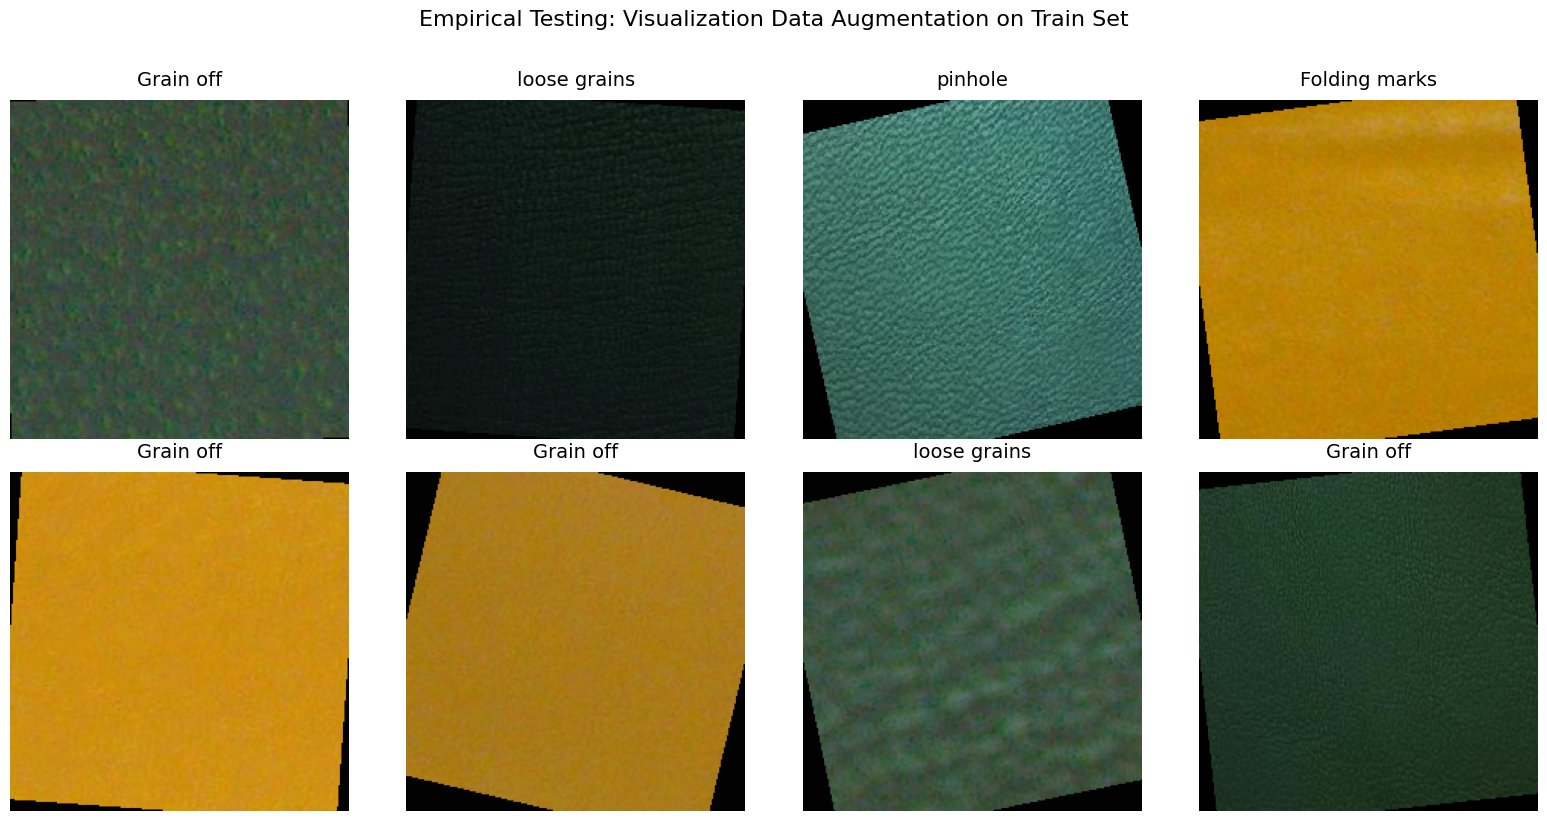

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Peschiamo un singolo batch (32 immagini) dal train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 2. Creiamo una figura con una griglia 2x4 (2 righe, 4 colonne)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Empirical Testing: Visualization Data Augmentation on Train Set",
             fontsize=16, y=1.02)

# Appiattiamo l'array degli assi per iterare più facilmente (da 2D a 1D)
axes = axes.flatten()

for i in range(8):
    # Estraiamo l'immagine i-esima
    img = images[i]

    # Denormalizziamo (moltiplichiamo per dev std 0.5 e sommiamo media 0.5)
    img = img / 2 + 0.5
    npimg = img.numpy()

    # Trasponiamo da (Color, Height, Width) a (Height, Width, Color)
    npimg = np.transpose(npimg, (1, 2, 0))

    # Plottiamo l'immagine nel suo riquadro
    axes[i].imshow(npimg)

    # Impostiamo il titolo usando il nome della classe e nascondiamo gli assi
    label_name = dataset.classes[labels[i]]
    axes[i].set_title(label_name, fontsize=14, pad=10)
    axes[i].axis('off')

# Ottimizza gli spazi tra le immagini
plt.tight_layout()
plt.show()

To verify the effectiveness of our preprocessing pipeline, we visualized a selection of images before and after applying data augmentation. By comparing the raw leather surfaces with their transformed counterparts, we can observe the impact of the rotation, scaling, and color jittering operations.

This step serves as a visual sanity check to ensure that the transformations introduce sufficient variability to prevent overfitting while preserving the distinctive features of each defect class.

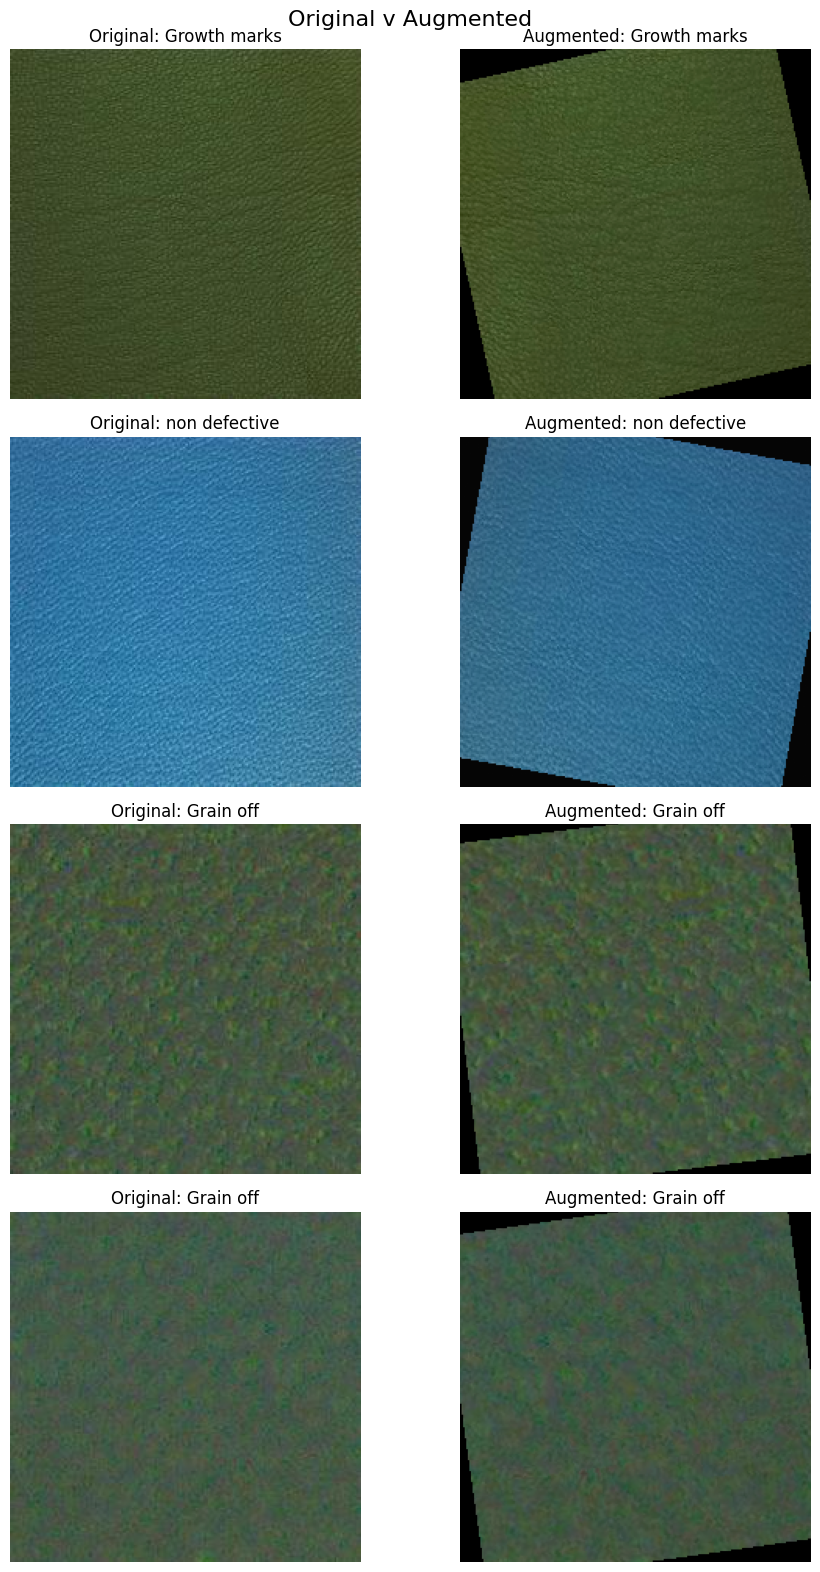

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. Scegliamo 4 indici casuali dal nostro training set
num_images = 4
random_indices = random.sample(range(len(train_final)), num_images)

# 2. Creiamo una griglia 4 righe x 2 colonne (Originale | Aumentata)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 4 * num_images))
fig.suptitle("Original v Augmented", fontsize=16)

for i, idx in enumerate(random_indices):
    # --- RECUPERO IMMAGINI ---
    # Immagine originale (saltiamo il wrapper accedendo a .subset)
    orig_img, label_idx = train_final.subset[idx]

    # Immagine aumentata (usiamo il wrapper normale)
    aug_tensor, _ = train_final[idx]

    # --- DENORMALIZZAZIONE TENSOR ---
    aug_img = aug_tensor / 2 + 0.5  # Riportiamo i valori nel range visibile
    aug_np = aug_img.numpy()
    aug_np = np.transpose(aug_np, (1, 2, 0)) # Da (Color, H, W) a (H, W, Color)

    label_name = dataset.classes[label_idx]

    # --- PLOT ORIGINALE (Colonna Sinistra) ---
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {label_name}", fontsize=12)
    axes[i, 0].axis('off')

    # --- PLOT AUMENTATA (Colonna Destra) ---
    axes[i, 1].imshow(aug_np)
    axes[i, 1].set_title(f"Augmented: {label_name}", fontsize=12)
    axes[i, 1].axis('off')

# Ottimizziamo gli spazi e mostriamo
plt.tight_layout()
plt.show()

# **Model 1: Classification**

Our first model is a multiclass classifier based on the ResNet-18 architecture. The task consists of mapping the input images into one of the six leather defect categories defined in the dataset.

# **Architettura ResidualBlock e ResNet-18**

In [ ]:
import torch
import torch.nn as nn

# ==========================================
# 1. IL MATTONCINO BASE: IL RESIDUAL BLOCK
# ==========================================
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        # Prima convoluzione del blocco (qui avviene l'eventuale riduzione spaziale se stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Seconda convoluzione del blocco
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # --- SKIP CONNECTION (La scorciatoia) ---
        self.shortcut = nn.Sequential()
        # Se cambiamo dimensione (stride != 1) o numero di canali, dobbiamo
        # adattare anche la "scorciatoia" con una convoluzione 1x1 per poter fare la somma finale
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x) # Salviamo l'input (o la sua versione adattata)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # IL CUORE DELLA RESNET: Sommiamo l'input all'output prima della ReLU finale
        out += identity
        out = self.relu(out)
        return out

import torch
import torch.nn as nn

# ==========================================
# 2. L'ARCHITETTURA: RESNET-18 (Senza MaxPool)
# ==========================================
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomResNet18, self).__init__()
        self.in_channels = 64

        # --- STRATO INIZIALE ---
        # Accetta immagini RGB (3 canali)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ❌ RIMOSSO: self.maxpool = nn.MaxPool2d(...)

        # --- I 4 STRATI DI BLOCCHI RESIDUI ---
        self.layer1 = self._make_layer(64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(512, num_blocks=2, stride=2)

        # --- CLASSIFICATORE FINALE ---
        # L'AdaptiveAvgPool è magico: non gli importa se in ingresso arrivano
        # tensori 7x7 o 14x14, li schiaccerà sempre e comunque a 1x1.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride=s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # Passaggio iniziale
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # ❌ RIMOSSO: x = self.maxpool(x)

        # Passaggio nei blocchi residui
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Classificazione
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# Mettiamo la GPU

In [ ]:
# Impostiamo il device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device in uso: {device}")

# Creiamo il nostro modello da zero specificando le 6 classi
model = CustomResNet18(num_classes=6)

# Spostiamo tutto sulla GPU
model = model.to(device)

Device in uso: cuda:0


In [ ]:
import torch.optim as optim
import time
import torch.nn as nn
import torch

# 1. Configurazione Loss e Ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. Impostazioni del ciclo di addestramento
num_epochs = 40
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Inizio addestramento...")

for epoch in range(num_epochs):
    start_time = time.time()

    # --- FASE DI ADDESTRAMENTO ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train

    # --- FASE DI VALIDAZIONE ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    # Salvataggio metriche
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_time = time.time() - start_time

    print(f"Epoca [{epoch+1:2d}/{num_epochs}] - Tempo: {epoch_time:.0f}s")
    print(f"  Train -> Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")
    print(f"  Val   -> Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}%")
    print("-" * 30)

print("Addestramento terminato.")

Inizio addestramento...
Epoca [ 1/40] - Tempo: 7s
  Train -> Loss: 1.3316 | Accuracy: 46.43%
  Val   -> Loss: 3.4883 | Accuracy: 51.11%
------------------------------
Epoca [ 2/40] - Tempo: 6s
  Train -> Loss: 1.1752 | Accuracy: 52.38%
  Val   -> Loss: 1.2672 | Accuracy: 48.89%
------------------------------
Epoca [ 3/40] - Tempo: 7s
  Train -> Loss: 1.1175 | Accuracy: 54.29%
  Val   -> Loss: 1.0575 | Accuracy: 52.22%
------------------------------
Epoca [ 4/40] - Tempo: 6s
  Train -> Loss: 1.0908 | Accuracy: 53.81%
  Val   -> Loss: 1.2697 | Accuracy: 54.44%
------------------------------
Epoca [ 5/40] - Tempo: 7s
  Train -> Loss: 1.1805 | Accuracy: 52.14%
  Val   -> Loss: 3.2733 | Accuracy: 52.22%
------------------------------
Epoca [ 6/40] - Tempo: 6s
  Train -> Loss: 1.1551 | Accuracy: 49.76%
  Val   -> Loss: 1.1083 | Accuracy: 55.56%
------------------------------
Epoca [ 7/40] - Tempo: 7s
  Train -> Loss: 1.0791 | Accuracy: 53.33%
  Val   -> Loss: 0.7848 | Accuracy: 71.11%
------

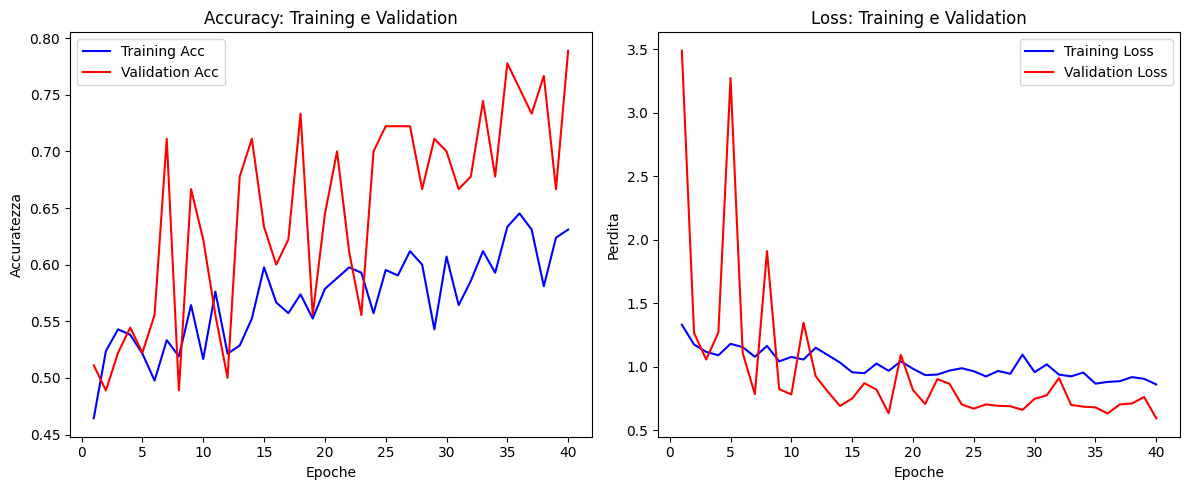

In [ ]:
def plot_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Grafico Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.title('Accuracy: Training e Validation')
    plt.xlabel('Epoche')
    plt.ylabel('Accuratezza')
    plt.legend()

    # Grafico Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss: Training e Validation')
    plt.xlabel('Epoche')
    plt.ylabel('Perdita')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# **Salvataggio finale del Checkpoint**

In [ ]:
# --- SALVATAGGIO FINALE DEL CHECKPOINT ---
print("Addestramento terminato. Salvataggio del checkpoint su Drive...")

checkpoint_path = '/content/drive/MyDrive/00gerem00/DL-AI-Project/resnet18_leather_checkpoint.pth'

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss,
    'history': history
}, checkpoint_path)

Addestramento terminato. Salvataggio del checkpoint su Drive...


# **MODEL EVALUATION**

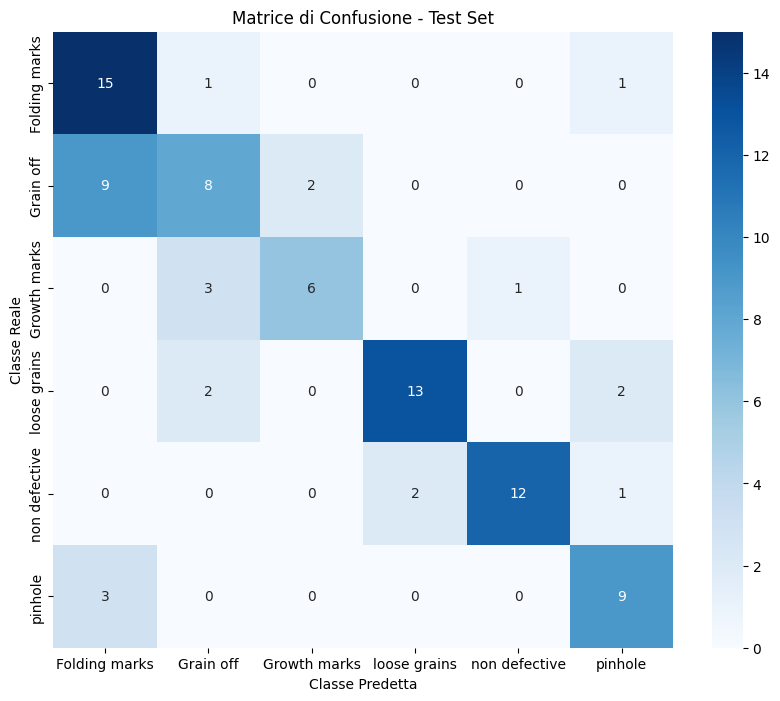


Report di Classificazione:
               precision    recall  f1-score   support

Folding marks       0.56      0.88      0.68        17
    Grain off       0.57      0.42      0.48        19
 Growth marks       0.75      0.60      0.67        10
 loose grains       0.87      0.76      0.81        17
non defective       0.92      0.80      0.86        15
      pinhole       0.69      0.75      0.72        12

     accuracy                           0.70        90
    macro avg       0.73      0.70      0.70        90
 weighted avg       0.72      0.70      0.70        90



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
y_true = []
y_pred = []

# Disabilitiamo il calcolo dei gradienti per velocizzare
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Riportiamo i dati sulla CPU per sklearn
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 1. Calcoliamo la Matrice di Confusione
cm = confusion_matrix(y_true, y_pred)
classes = dataset.classes

# 2. Visualizzazione con Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Matrice di Confusione - Test Set')
plt.ylabel('Classe Reale')
plt.xlabel('Classe Predetta')
plt.show()

# 3. Report completo (Precision, Recall, F1-Score)
print("\nReport di Classificazione:")
print(classification_report(y_true, y_pred, target_names=classes))